In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from tqdm import tqdm
tqdm.pandas()
%matplotlib inline

In [12]:
from transformers import BertTokenizer

In [13]:
data = pd.read_csv("/content/text.csv", usecols=['text', 'label'])

In [14]:
data

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


Each entry in this dataset consists of a text segment representing a Twitter message and a corresponding label indicating the predominant emotion conveyed. The emotions are classified into six categories:
1. sadness (0)
2. joy (1)
3. love (2)
4. anger (3)
5. fear (4)
6. surprise (5)

In [15]:
# checking all the distince characters in the tweet
unique_chars = ' '.join(data.text.tolist())
unique_chars = sorted((list(set(unique_chars))))
print(unique_chars)

# we can conclude that the data is already clean, so we dont need to do any preprocessing

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [16]:
def text_preprocessing(text):
    text = text.replace('ive', 'i have')
    text = text.replace('dont', 'do not')
    text = text.replace('cant', 'can not')
    text = text.replace('didnt', 'did not')
    text = text.replace('wasnt', 'was not')
    text = text.replace('thats', 'that is')
    text = text.replace('wont', 'would not')
    text = text.replace('havent', 'have not')
    text = text.replace('testimoney', 'testimony')
    text = text.replace('doesnt', 'does not')
    text = text.replace('youre', 'you are')
    text = text.replace('positi', 'positive')
    text = text.replace('couldnt', 'could not')
    text = text.replace('theres', 'there is')
    text = text.replace('isnt', 'is not')
    text = text.replace('wouldnt', 'would not')
    listOfWords = text.split()
    for i in range(len(listOfWords)):
        if listOfWords[i]=='havely' or listOfWords[i]=='haved':
            listOfWords[i] = listOfWords[i][2:]
    sentence = ''
    for i in range(len(listOfWords)-1):
        if listOfWords[i+1] == 'vely' or listOfWords[i+1] == 'ved':
            sentence = sentence + ' ' + listOfWords[i] + listOfWords[i+1]
            i = i+1
        else:
            sentence = sentence + ' ' + listOfWords[i]
    text = sentence

    return text

In [17]:
data.text = data.text.progress_apply(text_preprocessing)

100%|██████████| 416809/416809 [00:06<00:00, 65505.08it/s]


In [18]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [27]:
encoded_data = []
for sentence in tqdm(data.text.tolist()):
    encoded_data.append(tokenizer(sentence, return_tensors='pt', max_length=185, padding='max_length', truncation=True))

100%|██████████| 416809/416809 [06:11<00:00, 1123.47it/s]


In [43]:
length_data = [len(x) for x in encoded_data]
maxlen = max(length_data)
maxlen

185

In [41]:
encoded_data = [x.squeeze().tolist() for x in encoded_data]

<Axes: ylabel='Count'>

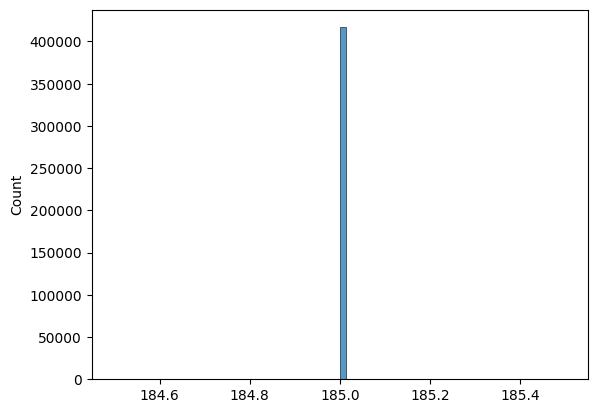

In [44]:
sns.histplot(length_data, bins=80)

In [45]:
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

In [46]:
# padded_data = pad_sequences(encoded_data, maxlen=185, padding='post')
labels = to_categorical(data.label)

In [47]:
labels

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [48]:
padded_np = np.array(encoded_data)
print(f"train_data shape: {padded_np.shape}, train_label shape: {labels.shape}")
print(f"train_data max embedding: {np.max(padded_np)}")

train_data shape: (416809, 185), train_label shape: (416809, 6)
train_data max embedding: 29611


In [67]:
from tensorflow.keras.layers import GRU, Bidirectional, Embedding, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
UNITS = 256

lstm_model_basic = Sequential()
lstm_model_basic.add(Embedding(29612, 15, input_shape=(padded_np.shape[1], )))
lstm_model_basic.add(Bidirectional(GRU(units=UNITS, return_sequences=True)))
lstm_model_basic.add(Bidirectional(GRU(units=128, return_sequences=True)))
lstm_model_basic.add(BatchNormalization())
# lstm_model_basic.add(Dense(128, activation='relu'))
# lstm_model_basic.add(Dense(32, activation='relu'))
# lstm_model_basic.add(Dense(8, activation='relu'))
lstm_model_basic.add(Bidirectional(GRU(units=128)))
lstm_model_basic.add(Dense(6, activation='softmax'))

In [68]:
# adam = Adam(learning_rate=1e-3)
lstm_model_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [69]:
lstm_model_basic.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 185, 15)           444180    
                                                                 
 bidirectional_9 (Bidirecti  (None, 185, 512)          419328    
 onal)                                                           
                                                                 
 bidirectional_10 (Bidirect  (None, 185, 256)          493056    
 ional)                                                          
                                                                 
 batch_normalization_1 (Bat  (None, 185, 256)          1024      
 chNormalization)                                                
                                                                 
 bidirectional_11 (Bidirect  (None, 256)               296448    
 ional)                                               

In [ ]:
history = lstm_model_basic.fit(padded_np, labels, epochs=5, batch_size=32, validation_split=0.3)

Epoch 1/5
9118/9118 [==============================] - 690s 74ms/step - loss: 0.3747 - acc: 0.8388 - val_loss: 0.3683 - val_acc: 0.8413
Epoch 2/5
8271/9118 [==========================>...] - ETA: 46s - loss: 0.3149 - acc: 0.8607

1. With just 10000 samples for testing, we were able to achieve an accuracy of `70%` over the validation dataset using Bidirectional GRU.
2. With complete dataset and 2 Bidirectional GRUs, we are able to get an accuracy of `86%` over the validation dataset.